In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModelForCausalLM,GPT2Tokenizer
import requests


In [2]:
# load pretrained GPT-2 model and tokenizer
gpt2 = AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [3]:
# hyperparameters
seq_len    = 256 # max sequence length
batch_size =  16

# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# tokenize Gulliver's travels
text = requests.get('https://www.gutenberg.org/cache/epub/829/pg829.txt').text
gtTokens = tokenizer.encode(text,return_tensors='pt')[0]

for name,param in gpt2.named_parameters():
  if '.h.' in name:
    param.requires_grad = False
    print(f'--- Layer {name} is frozen (.requires_grad = {param.requires_grad}).')

  elif '.h.' not in name:
    print(f'+++ Layer {name} is trainable (.requires_grad = {param.requires_grad}).')




Token indices sequence length is longer than the specified maximum sequence length for this model (158345 > 1024). Running this sequence through the model will result in indexing errors


+++ Layer transformer.wte.weight is trainable (.requires_grad = True).
+++ Layer transformer.wpe.weight is trainable (.requires_grad = True).
--- Layer transformer.h.0.ln_1.weight is frozen (.requires_grad = False).
--- Layer transformer.h.0.ln_1.bias is frozen (.requires_grad = False).
--- Layer transformer.h.0.attn.c_attn.weight is frozen (.requires_grad = False).
--- Layer transformer.h.0.attn.c_attn.bias is frozen (.requires_grad = False).
--- Layer transformer.h.0.attn.c_proj.weight is frozen (.requires_grad = False).
--- Layer transformer.h.0.attn.c_proj.bias is frozen (.requires_grad = False).
--- Layer transformer.h.0.ln_2.weight is frozen (.requires_grad = False).
--- Layer transformer.h.0.ln_2.bias is frozen (.requires_grad = False).
--- Layer transformer.h.0.mlp.c_fc.weight is frozen (.requires_grad = False).
--- Layer transformer.h.0.mlp.c_fc.bias is frozen (.requires_grad = False).
--- Layer transformer.h.0.mlp.c_proj.weight is frozen (.requires_grad = False).
--- Layer tr

In [5]:
# as a sanity-check, grab weights from one frozen and one trainable layer
frozenW_pre = gpt2.transformer.h[6].mlp.c_fc.weight.data
trainW_pre  = gpt2.transformer.ln_f.weight.data


In [6]:
# move the model to the GPU
gpt2 = gpt2.to(device)

In [7]:
# create the optimizer functions
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=5e-5, weight_decay=.01)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Sample    0/123, train loss: 5.3849
Sample   27/123, train loss: 5.1868
Sample   54/123, train loss: 4.8730
Sample   81/123, train loss: 4.8263
Sample  108/123, train loss: 4.5179


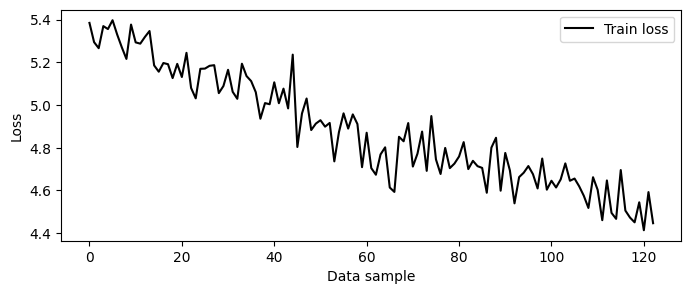

In [8]:
num_samples = 123

# initialize losses
train_loss = []

for sampli in range(num_samples):
   # get a batch of data
  ix = torch.randint(len(gtTokens)-seq_len,size=(batch_size,))
  X  = gtTokens[ix[:,None] + torch.arange(seq_len)].to(device)

  # forward pass (Hugging Face shifts X internally to get y)
  gpt2.zero_grad()
  outputs = gpt2(X,labels=X)
  loss = outputs.loss

  # backprop
  loss.backward()
  optimizer.step()

  # store the per-sample loss
  train_loss.append( loss.item() )

  # update progress display
  if sampli%27==0:
    print(f'Sample {sampli:4}/{num_samples}, train loss: {train_loss[-1]:.4f}')

# plot the losses
plt.figure(figsize=(8,3))
plt.plot(train_loss,'k',markersize=8,label='Train loss')

plt.legend()
plt.gca().set(xlabel='Data sample',ylabel='Loss')
plt.show()



In [9]:
# grab the weight matrices again
frozenW_pst = gpt2.transformer.h[6].mlp.c_fc.weight.data.cpu()
trainW_pst  = gpt2.transformer.ln_f.weight.data.cpu()

# should be all zeros if the layer was frozen
print('Frozen layer, norm(post-pre):')
print('  ',torch.norm(frozenW_pst - frozenW_pre))

print('\nTrainable layer, norm(post-pre):')
print('  ',torch.norm(trainW_pst - trainW_pre))


Frozen layer, norm(post-pre):
   tensor(0.)

Trainable layer, norm(post-pre):
   tensor(0.1193)
